In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import lfilter
import librosa
import librosa.display
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

In [1]:
def extract_lpccs(audio, sr, n_lpcc=13, n_lpc=12):
    """
    Extract LPCC features using scipy and numpy
    """
    # Pre-emphasis
    audio_preemph = lfilter([1, -0.97], [1], audio)
    
    # Frame parameters
    frame_length = int(0.025 * sr)  # 25ms
    hop_length = int(0.010 * sr)    # 10ms
    
    # Get frames using librosa
    frames = librosa.util.frame(audio_preemph, frame_length=frame_length, hop_length=hop_length)
    
    # Apply window
    window = signal.windows.hamming(frame_length)
    frames = frames.T * window
    
    # Extract LPCCs for each frame
    lpccs = []
    lpcs = []
    
    for frame in frames:
        # Compute autocorrelation
        r = np.correlate(frame, frame, mode='full')
        r = r[len(r)//2:][:n_lpc+1]
        
        # Solve Yule-Walker equations for LPC coefficients
        # Using numpy's linear algebra solver
        R = np.zeros((n_lpc, n_lpc))
        for i in range(n_lpc):
            for j in range(n_lpc):
                R[i, j] = r[abs(i-j)]
        
        b = r[1:n_lpc+1]
        a = np.linalg.solve(R, b)
        lpcs.append(a)
        
        # Convert LPC to LPCC
        lpcc = np.zeros(n_lpcc)
        lpcc[0] = a[0]
        
        for m in range(1, min(n_lpc, n_lpcc)):
            lpcc[m] = a[m]
            for k in range(1, m):
                lpcc[m] += (k+1)/(m+1) * lpcc[k] * a[m-k-1]
        
        for m in range(n_lpc, n_lpcc):
            for k in range(m-n_lpc, m):
                lpcc[m] += (k+1)/(m+1) * lpcc[k] * a[m-k-1]
        
        lpccs.append(lpcc)
    
    return np.array(lpccs), np.array(lpcs)


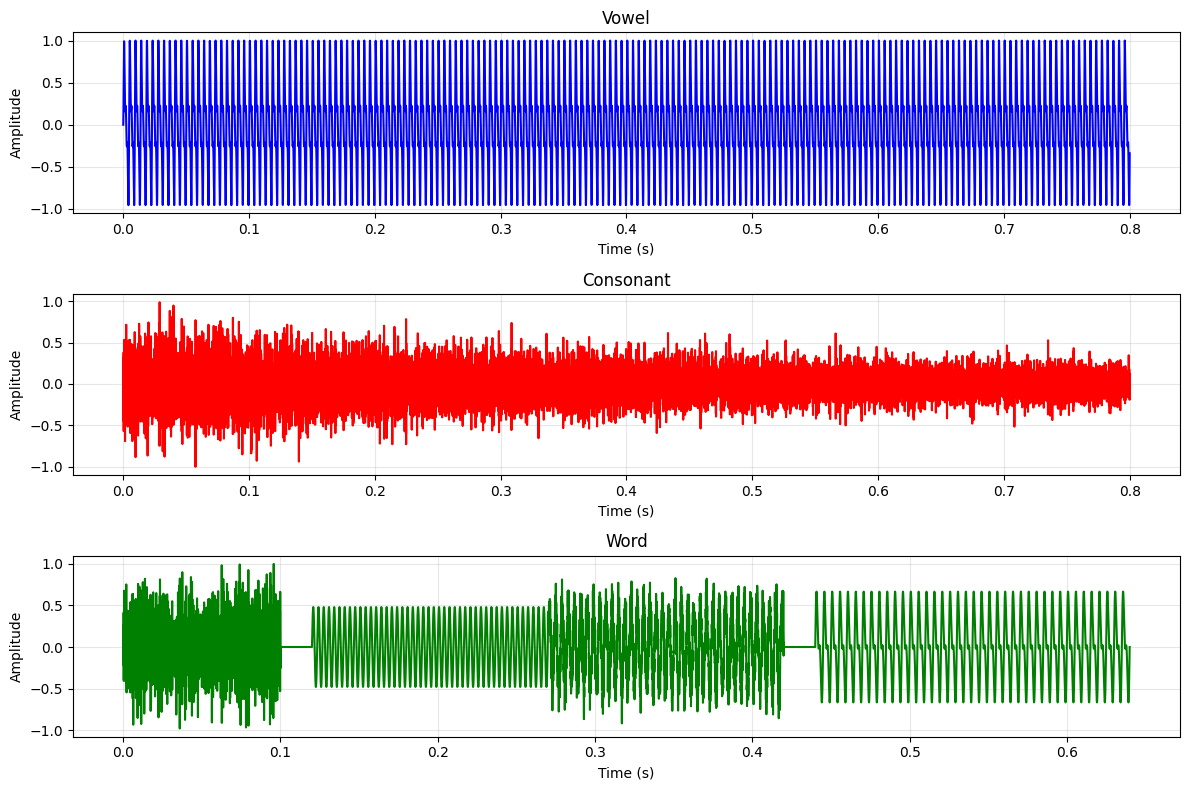

In [4]:
sr = 16000
duration = 0.8

# Vowel: sine waves at harmonics
t = np.linspace(0, duration, int(sr * duration))
vowel = np.sin(2*np.pi*220*t) + 0.6*np.sin(2*np.pi*440*t) + 0.4*np.sin(2*np.pi*660*t)
vowel = lfilter([1], [1, -1.5, 0.64], vowel)
vowel = vowel / np.max(np.abs(vowel))

# Consonant: filtered noise
consonant = np.random.randn(int(sr * duration))
consonant = lfilter([1, -0.95], [1], consonant)
consonant = consonant * (np.exp(-2*t) + 0.3)
consonant = consonant / np.max(np.abs(consonant))

# Word: concatenate phonemes
h = lfilter([1, -0.9], [1], np.random.randn(int(sr*0.1))) * 0.5
e = np.sin(2*np.pi*300*np.linspace(0, 0.15, int(sr*0.15)))
l = np.sin(2*np.pi*250*np.linspace(0, 0.15, int(sr*0.15))) + 0.3*np.random.randn(int(sr*0.15))
o = np.sin(2*np.pi*200*np.linspace(0, 0.2, int(sr*0.2))) + 0.6*np.sin(2*np.pi*400*np.linspace(0, 0.2, int(sr*0.2)))
gap = np.zeros(int(sr*0.02))
hello = np.concatenate([h, gap, e, l, gap, o])
hello = hello / np.max(np.abs(hello))

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
for ax, sig, label, color in zip(axes, [vowel, consonant, hello], 
                                  ['Vowel', 'Consonant', 'Word'],
                                  ['blue', 'red', 'green']):
    ax.plot(np.arange(len(sig))/sr, sig, color=color)
    ax.set_title(label)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


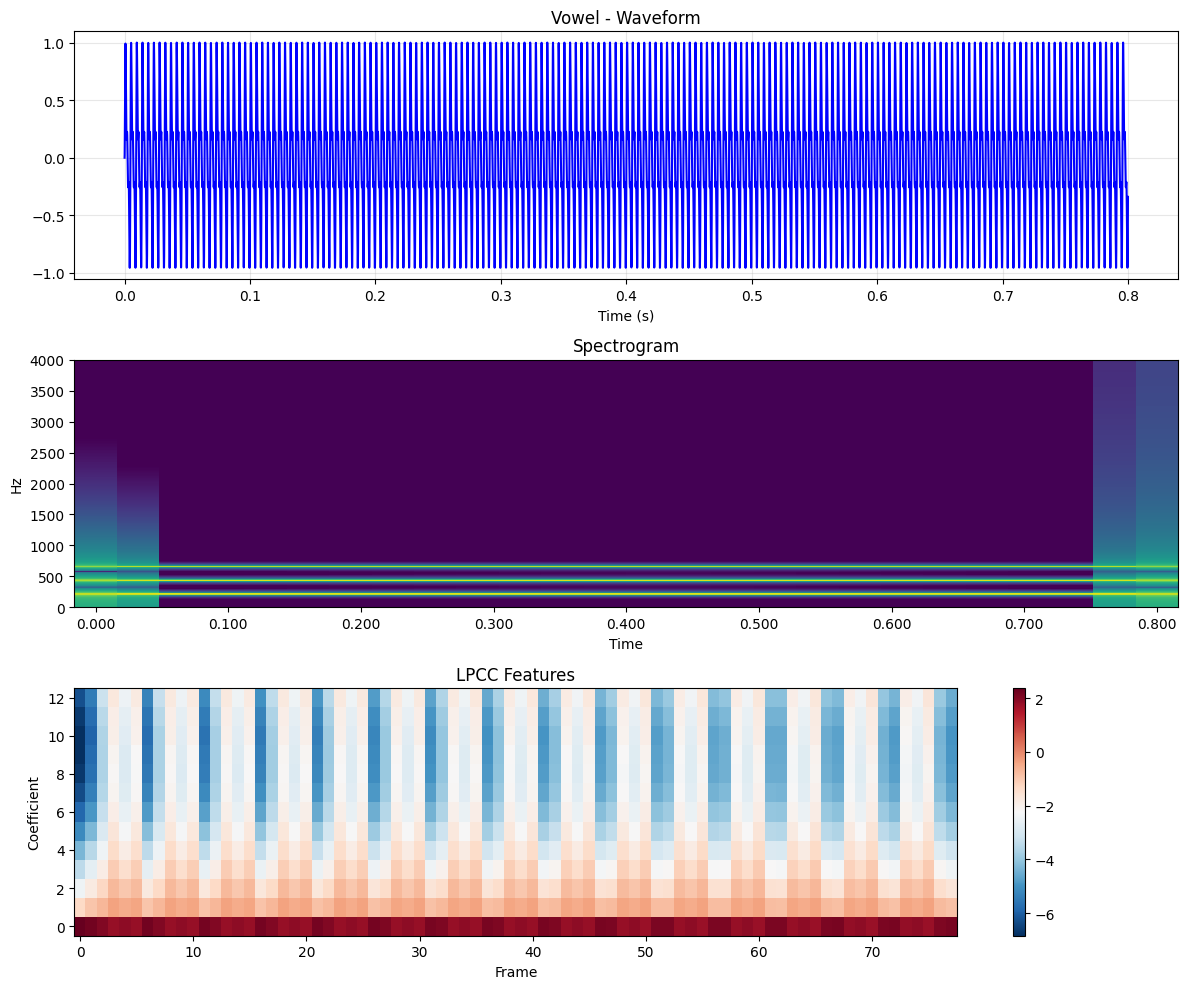

LPCC shape: (78, 13)


In [5]:
vowel_lpccs, vowel_lpcs = extract_lpccs(vowel, sr)

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Waveform
axes[0].plot(np.arange(len(vowel))/sr, vowel, color='blue')
axes[0].set_title('Vowel - Waveform')
axes[0].set_xlabel('Time (s)')
axes[0].grid(True, alpha=0.3)

# Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(vowel)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1], cmap='viridis')
axes[1].set_title('Spectrogram')
axes[1].set_ylim([0, 4000])

# LPCC heatmap
im = axes[2].imshow(vowel_lpccs.T, aspect='auto', origin='lower', cmap='RdBu_r')
axes[2].set_title('LPCC Features')
axes[2].set_xlabel('Frame')
axes[2].set_ylabel('Coefficient')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"LPCC shape: {vowel_lpccs.shape}")
display(Audio(vowel, rate=sr))

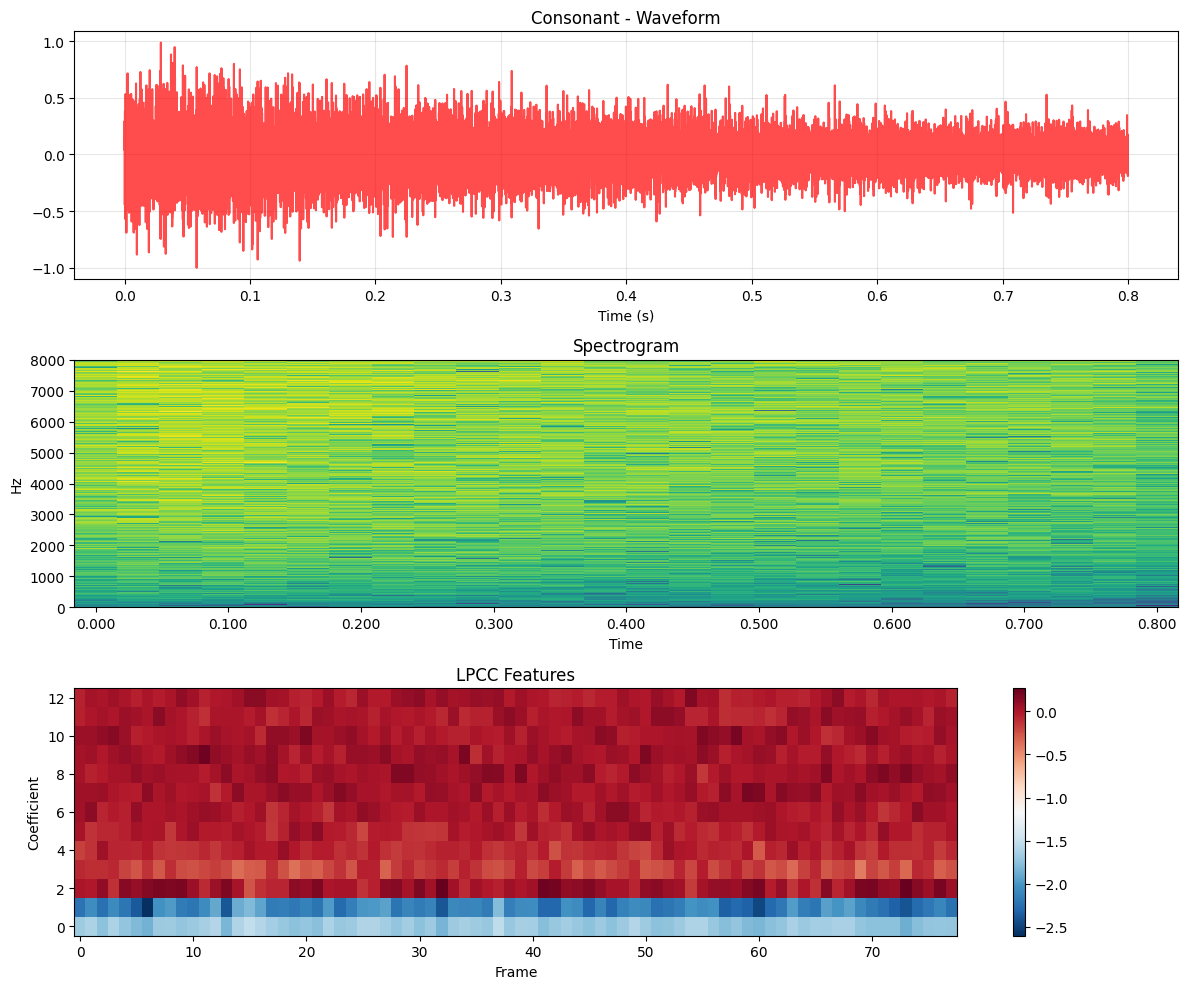

LPCC shape: (78, 13)


In [6]:
consonant_lpccs, consonant_lpcs = extract_lpccs(consonant, sr)

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Waveform
axes[0].plot(np.arange(len(consonant))/sr, consonant, color='red', alpha=0.7)
axes[0].set_title('Consonant - Waveform')
axes[0].set_xlabel('Time (s)')
axes[0].grid(True, alpha=0.3)

# Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(consonant)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1], cmap='viridis')
axes[1].set_title('Spectrogram')
axes[1].set_ylim([0, 8000])

# LPCC heatmap
im = axes[2].imshow(consonant_lpccs.T, aspect='auto', origin='lower', cmap='RdBu_r')
axes[2].set_title('LPCC Features')
axes[2].set_xlabel('Frame')
axes[2].set_ylabel('Coefficient')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"LPCC shape: {consonant_lpccs.shape}")
display(Audio(consonant, rate=sr))


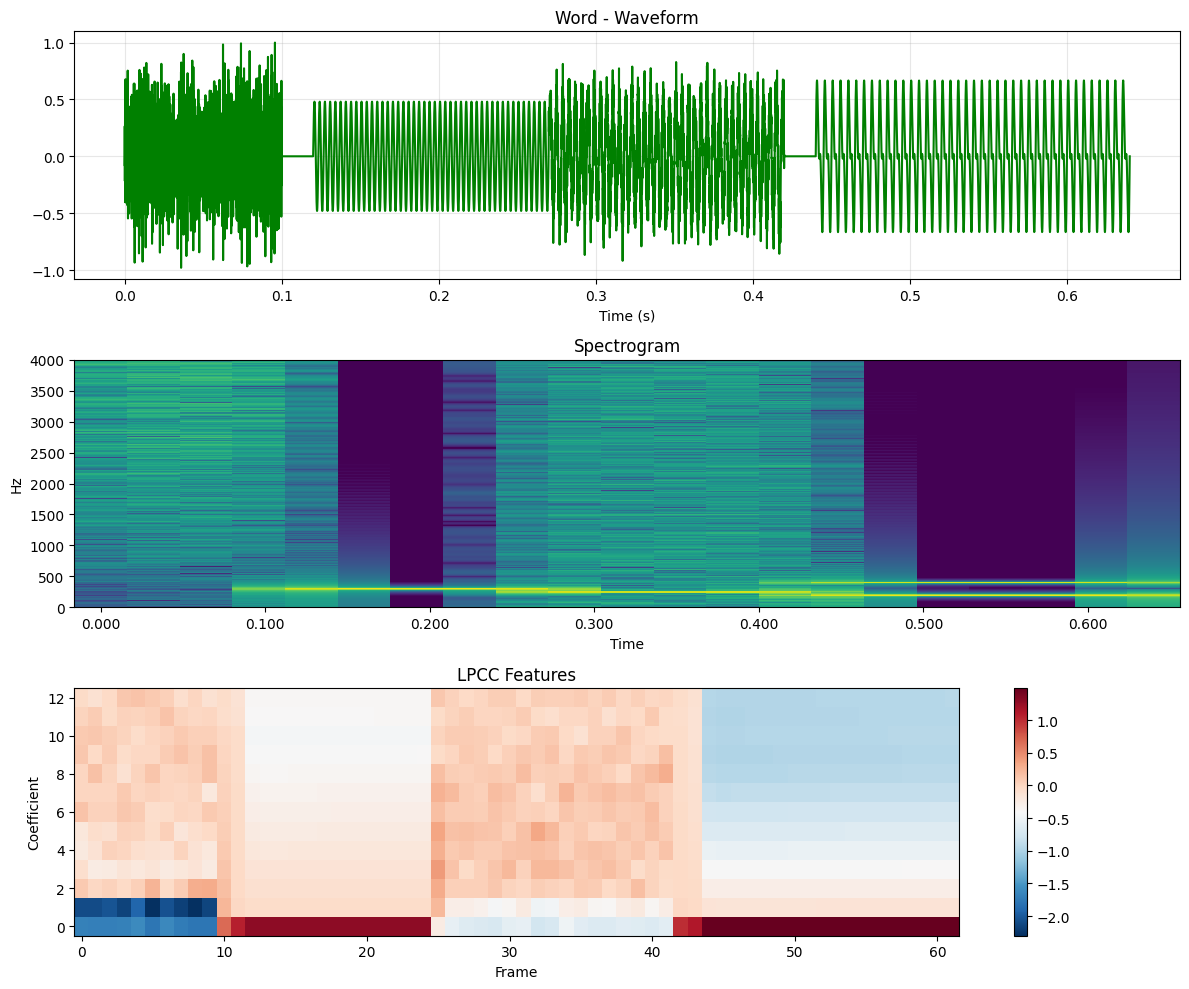

LPCC shape: (62, 13)


In [7]:
hello_lpccs, hello_lpcs = extract_lpccs(hello, sr)

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Waveform
axes[0].plot(np.arange(len(hello))/sr, hello, color='green')
axes[0].set_title('Word - Waveform')
axes[0].set_xlabel('Time (s)')
axes[0].grid(True, alpha=0.3)

# Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(hello)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1], cmap='viridis')
axes[1].set_title('Spectrogram')
axes[1].set_ylim([0, 4000])

# LPCC heatmap
im = axes[2].imshow(hello_lpccs.T, aspect='auto', origin='lower', cmap='RdBu_r')
axes[2].set_title('LPCC Features')
axes[2].set_xlabel('Frame')
axes[2].set_ylabel('Coefficient')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"LPCC shape: {hello_lpccs.shape}")
display(Audio(hello, rate=sr))


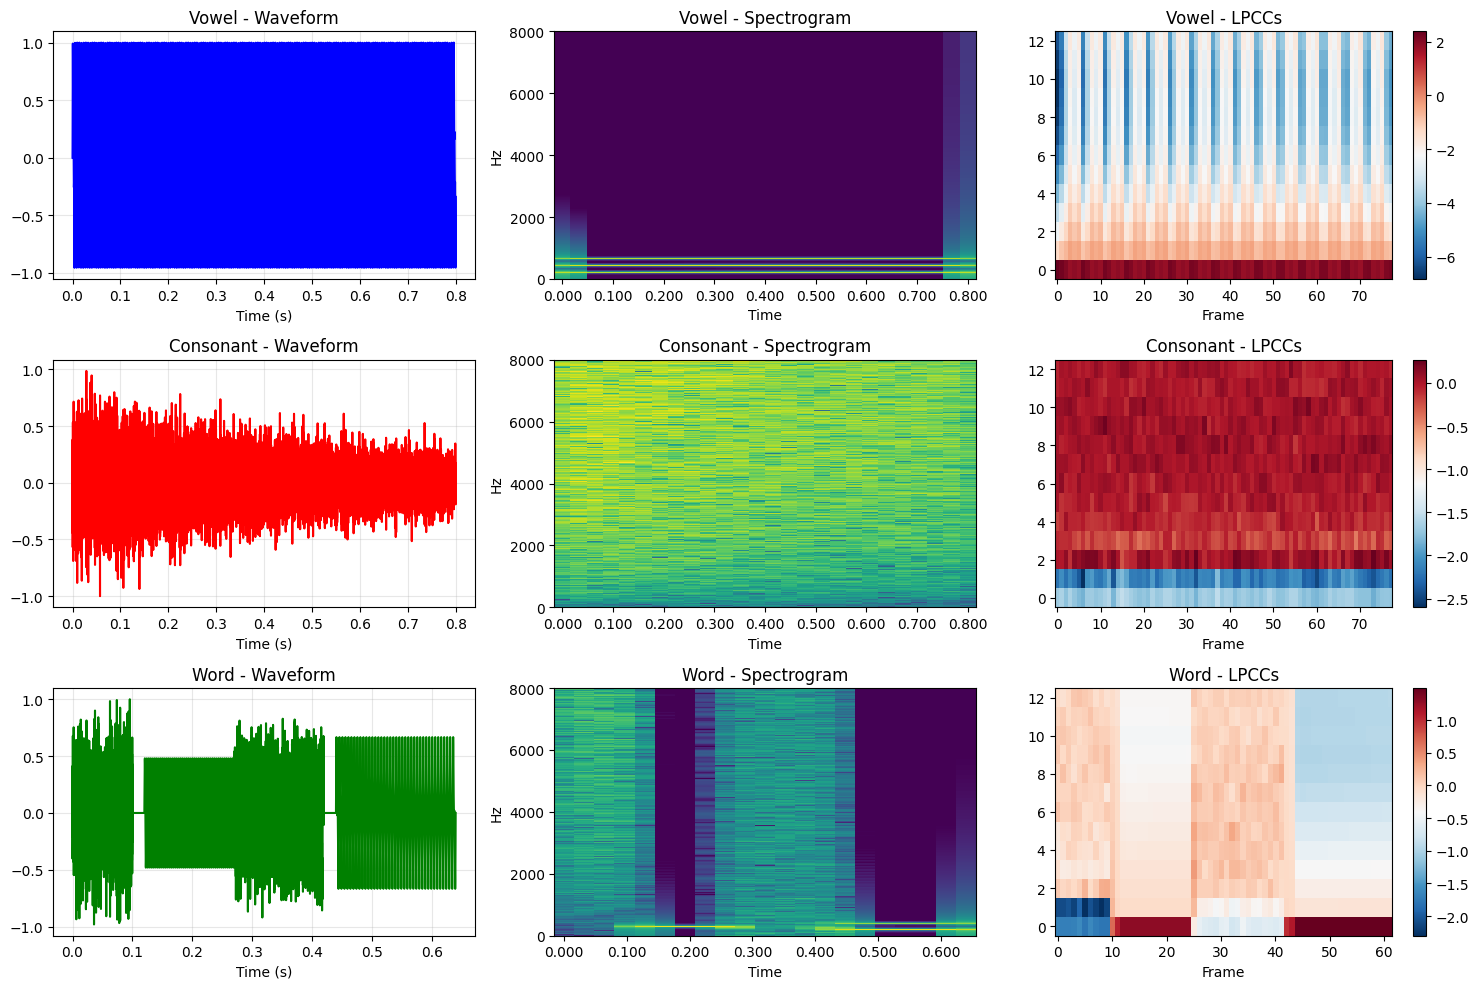


Comparison complete
Notice: Different sounds produce different LPCC patterns


In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

all_data = [
    (vowel, vowel_lpccs, 'Vowel', 'blue'),
    (consonant, consonant_lpccs, 'Consonant', 'red'),
    (hello, hello_lpccs, 'Word', 'green')
]

for i, (sig, lpccs, label, color) in enumerate(all_data):
    # Waveform
    axes[i, 0].plot(np.arange(len(sig))/sr, sig, color=color)
    axes[i, 0].set_title(f'{label} - Waveform')
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[i, 1], cmap='viridis')
    axes[i, 1].set_title(f'{label} - Spectrogram')
    
    # LPCC
    im = axes[i, 2].imshow(lpccs.T, aspect='auto', origin='lower', cmap='RdBu_r')
    axes[i, 2].set_title(f'{label} - LPCCs')
    axes[i, 2].set_xlabel('Frame')
    plt.colorbar(im, ax=axes[i, 2])

plt.tight_layout()
plt.show()

print("\nComparison complete")
print("Notice: Different sounds produce different LPCC patterns")


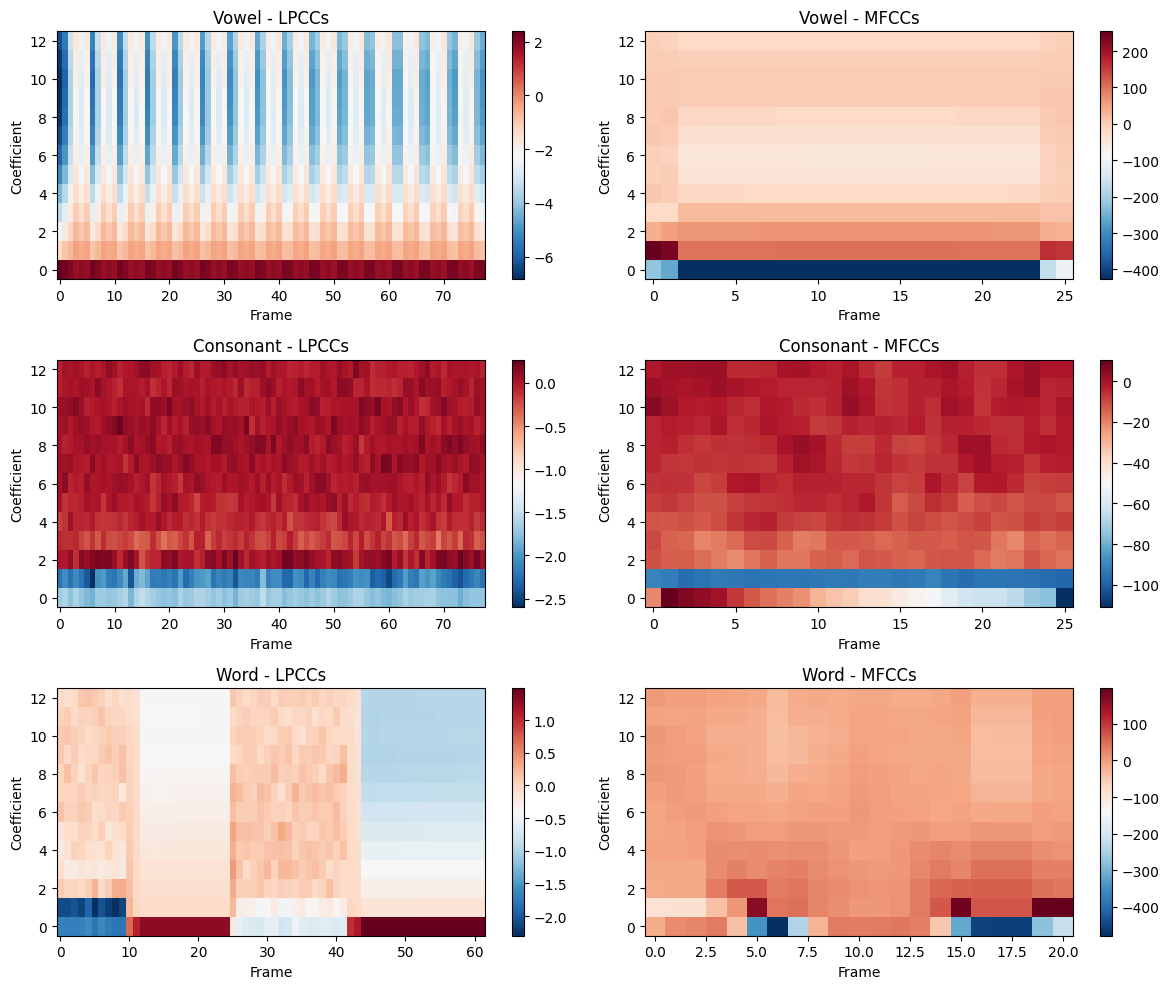


LPCCs: Linear prediction model (vocal tract)
MFCCs: Mel-scale model (human perception)
Both capture speech information effectively


In [11]:
vowel_mfccs = librosa.feature.mfcc(y=vowel, sr=sr, n_mfcc=13).T
consonant_mfccs = librosa.feature.mfcc(y=consonant, sr=sr, n_mfcc=13).T
hello_mfccs = librosa.feature.mfcc(y=hello, sr=sr, n_mfcc=13).T

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

comparisons = [
    ('Vowel', vowel_lpccs, vowel_mfccs),
    ('Consonant', consonant_lpccs, consonant_mfccs),
    ('Word', hello_lpccs, hello_mfccs)
]

for i, (label, lpccs, mfccs) in enumerate(comparisons):
    # LPCCs
    im1 = axes[i, 0].imshow(lpccs.T, aspect='auto', origin='lower', cmap='RdBu_r')
    axes[i, 0].set_title(f'{label} - LPCCs')
    axes[i, 0].set_xlabel('Frame')
    axes[i, 0].set_ylabel('Coefficient')
    plt.colorbar(im1, ax=axes[i, 0])
    
    # MFCCs
    im2 = axes[i, 1].imshow(mfccs.T, aspect='auto', origin='lower', cmap='RdBu_r')
    axes[i, 1].set_title(f'{label} - MFCCs')
    axes[i, 1].set_xlabel('Frame')
    axes[i, 1].set_ylabel('Coefficient')
    plt.colorbar(im2, ax=axes[i, 1])

plt.tight_layout()
plt.show()

print("\nLPCCs: Linear prediction model (vocal tract)")
print("MFCCs: Mel-scale model (human perception)")
print("Both capture speech information effectively")